<a href="https://colab.research.google.com/github/Mootha-sri-harshit/Stereo-Vision-and-Depth-Estimation/blob/main/Stereo_Vision_and_Depth_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install kagglehub opencv-python matplotlib numpy

import kagglehub
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import zipfile
from IPython.display import clear_output




In [4]:
# Download and prepare stereo dataset
print(" Starting stereo dataset preparation...")

def download_stereo_dataset():
    """Download stereo images dataset using KaggleHub"""
    try:
        # Download dataset from Kaggle using KaggleHub (no credentials needed for public datasets)
        dataset_path = kagglehub.dataset_download("ahmedhesham122000/stereo-images")
        print(f"Dataset downloaded successfully to: {dataset_path}")
        return dataset_path
    except Exception as e:
        print(f" Failed to download dataset: {str(e)}")
        print(" Creating sample stereo pairs for demonstration...")
        return create_sample_stereo_pairs()

def create_sample_stereo_pairs():
    """Create sample stereo pairs if download fails"""
    os.makedirs('sample_stereo_dataset', exist_ok=True)

    # Create realistic stereo pairs
    for i in range(1, 4):
        # Create left image with objects at different depths
        height, width = 400, 600
        img_left = np.ones((height, width), dtype=np.uint8) * 50

        # Add objects at different depths
        cv2.rectangle(img_left, (100, 100), (200, 200), 150, -1)  # Close object
        cv2.rectangle(img_left, (300, 150), (400, 250), 100, -1)  # Medium distance
        cv2.circle(img_left, (500, 300), 60, 200, -1)             # Close object
        cv2.rectangle(img_left, (50, 250), (150, 350), 180, -1)   # Another close object

        # Add texture noise
        noise = np.random.randint(-30, 30, (height, width), dtype=np.int16)
        img_left = np.clip(img_left.astype(np.int16) + noise, 0, 255).astype(np.uint8)

        # Create right image with disparity simulation
        img_right = np.zeros_like(img_left)
        for y in range(height):
            for x in range(width):
                # Apply different disparities based on intensity (depth simulation)
                pixel_val = img_left[y, x]
                if pixel_val > 170:  # Very close objects
                    disparity = 20
                elif pixel_val > 130:  # Close objects
                    disparity = 12
                elif pixel_val > 90:  # Medium distance objects
                    disparity = 6
                else:  # Background
                    disparity = 2

                new_x = max(0, x - disparity)
                img_right[y, new_x] = pixel_val

        # Save the stereo pair
        cv2.imwrite(f'sample_stereo_dataset/l{i}.png', img_left)
        cv2.imwrite(f'sample_stereo_dataset/r{i}.png', img_right)

    print(" Sample stereo pairs created successfully!")
    return 'sample_stereo_dataset'

def organize_stereo_pairs(dataset_path):
    """Organize downloaded stereo pairs"""
    if dataset_path is None:
        return None

    # Get all PNG files
    all_files = [f for f in os.listdir(dataset_path) if f.endswith('.png')]

    # Separate left and right images
    left_images = sorted([f for f in all_files if f.startswith('l')])
    right_images = sorted([f for f in all_files if f.startswith('r')])

    print(f" Found {len(left_images)} left images: {left_images}")
    print(f" Found {len(right_images)} right images: {right_images}")

    # Create stereo pairs
    stereo_pairs = []
    for left_file in left_images:
        left_num = left_file[1:].split('.')[0]
        corresponding_right = f'r{left_num}.png'

        if corresponding_right in right_images:
            left_path = os.path.join(dataset_path, left_file)
            right_path = os.path.join(dataset_path, corresponding_right)
            stereo_pairs.append((left_path, right_path))
            print(f" Paired: {left_file} <-> {corresponding_right}")

    return stereo_pairs

# Download stereo dataset
stereo_dataset_path = download_stereo_dataset()

if stereo_dataset_path is None:
    print(" Failed to download dataset. Please check your internet connection.")
else:
    # Organize stereo pairs
    stereo_pairs = organize_stereo_pairs(stereo_dataset_path)
    print(f" Stereo dataset prepared with {len(stereo_pairs)} pairs")


 Starting stereo dataset preparation...
Dataset downloaded successfully to: /kaggle/input/stereo-images
 Found 3 left images: ['l1.png', 'l2.png', 'l3.png']
 Found 3 right images: ['r1.png', 'r2.png', 'r3.png']
 Paired: l1.png <-> r1.png
 Paired: l2.png <-> r2.png
 Paired: l3.png <-> r3.png
 Stereo dataset prepared with 3 pairs


In [5]:
# Core stereo vision functions
def create_stereo_matcher(algorithm='SGBM', **params):
    """Create stereo matching algorithm with optimized parameters"""

    if algorithm == 'BM':
        # StereoBM parameters optimized for general use
        stereo = cv2.StereoBM_create(
            numDisparities=params.get('numDisparities', 32),
            blockSize=params.get('blockSize', 9)
        )
        print("🔧 Created StereoBM matcher")

    else:  # SGBM - default and recommended choice
        # StereoSGBM parameters optimized for better accuracy
        block_size = params.get('blockSize', 5)
        num_disp = params.get('numDisparities', 32)

        stereo = cv2.StereoSGBM_create(
            minDisparity=params.get('minDisparity', 0),
            numDisparities=num_disp,
            blockSize=block_size,
            P1=params.get('P1', 8 * 3 * block_size**2),
            P2=params.get('P2', 32 * 3 * block_size**2),
            disp12MaxDiff=params.get('disp12MaxDiff', 2),
            uniquenessRatio=params.get('uniquenessRatio', 15),
            speckleWindowSize=params.get('speckleWindowSize', 50),
            speckleRange=params.get('speckleRange', 16),
            preFilterCap=params.get('preFilterCap', 63),
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )
        print(" Created StereoSGBM matcher with optimized parameters")

    return stereo

def load_and_preprocess_stereo_pair(left_path, right_path):
    """Load and preprocess stereo image pair"""
    # Load images
    img_left = cv2.imread(left_path, cv2.IMREAD_GRAYSCALE)
    img_right = cv2.imread(right_path, cv2.IMREAD_GRAYSCALE)

    if img_left is None or img_right is None:
        raise ValueError(f"Could not load images: {left_path}, {right_path}")

    # Ensure both images have the same dimensions
    if img_left.shape != img_right.shape:
        print(" Warning: Image dimensions don't match. Resizing...")
        min_height = min(img_left.shape[0], img_right.shape[0])
        min_width = min(img_left.shape[1], img_right.shape[1])
        img_left = cv2.resize(img_left, (min_width, min_height))
        img_right = cv2.resize(img_right, (min_width, min_height))

    # Apply preprocessing to reduce noise
    img_left_processed = cv2.GaussianBlur(img_left, (3, 3), 0)
    img_right_processed = cv2.GaussianBlur(img_right, (3, 3), 0)

    print(f" Loaded and preprocessed stereo pair - Size: {img_left.shape}")

    return img_left, img_right, img_left_processed, img_right_processed

def compute_disparity_map(img_left, img_right, stereo_matcher):
    """Compute disparity map with post-processing"""
    print(" Computing disparity map...")

    # Compute disparity
    disparity = stereo_matcher.compute(img_left, img_right)

    # Convert to float and normalize
    disparity = disparity.astype(np.float32) / 16.0

    # Apply post-processing filter to reduce noise
    disparity_filtered = cv2.medianBlur(disparity.astype(np.uint8), 5).astype(np.float32)

    print(f" Disparity computed - Shape: {disparity.shape}")
    print(f" Disparity range: {disparity.min():.2f} to {disparity.max():.2f}")

    return disparity_filtered

def convert_disparity_to_depth(disparity, focal_length=500.0, baseline=0.1):
    """Convert disparity map to depth map using camera parameters"""
    print(" Converting disparity to depth...")

    # Create depth map
    depth = np.zeros_like(disparity)
    valid_pixels = disparity > 0

    # Apply depth calculation: depth = (focal_length * baseline) / disparity
    depth[valid_pixels] = (focal_length * baseline) / (disparity[valid_pixels] + 1e-6)

    # Clip unrealistic depth values (limit to reasonable range)
    depth = np.clip(depth, 0, 50)  # Maximum 50 meters

    print(f" Depth computed - Valid pixels: {valid_pixels.sum()}")
    if valid_pixels.sum() > 0:
        print(f"📏 Depth range: {depth[valid_pixels].min():.2f} to {depth[valid_pixels].max():.2f} meters")

    return depth

print(" Core stereo vision functions loaded successfully!")


 Core stereo vision functions loaded successfully!


In [6]:
# Process all stereo pairs
print(" Starting stereo vision processing...")

def process_single_stereo_pair(left_path, right_path, pair_id):
    """Process a single stereo pair and return results"""
    try:
        # Load and preprocess images
        img_left_orig, img_right_orig, img_left_proc, img_right_proc = load_and_preprocess_stereo_pair(left_path, right_path)

        # Create stereo matchers
        stereo_bm = create_stereo_matcher('BM', numDisparities=32, blockSize=9)
        stereo_sgbm = create_stereo_matcher('SGBM', numDisparities=32, blockSize=5)

        # Compute disparity maps using both algorithms
        print(f" Processing with StereoBM...")
        disparity_bm = compute_disparity_map(img_left_proc, img_right_proc, stereo_bm)

        print(f" Processing with StereoSGBM...")
        disparity_sgbm = compute_disparity_map(img_left_proc, img_right_proc, stereo_sgbm)

        # Convert to depth maps
        depth_bm = convert_disparity_to_depth(disparity_bm)
        depth_sgbm = convert_disparity_to_depth(disparity_sgbm)

        # Calculate quality metrics
        valid_pixels_bm = (disparity_bm > 0).sum()
        valid_pixels_sgbm = (disparity_sgbm > 0).sum()
        coverage_bm = valid_pixels_bm / disparity_bm.size * 100
        coverage_sgbm = valid_pixels_sgbm / disparity_sgbm.size * 100

        result = {
            'pair_id': pair_id,
            'left_image_orig': img_left_orig,
            'right_image_orig': img_right_orig,
            'disparity_bm': disparity_bm,
            'disparity_sgbm': disparity_sgbm,
            'depth_bm': depth_bm,
            'depth_sgbm': depth_sgbm,
            'coverage_bm': coverage_bm,
            'coverage_sgbm': coverage_sgbm,
            'valid_pixels_bm': valid_pixels_bm,
            'valid_pixels_sgbm': valid_pixels_sgbm
        }

        print(f" Pair {pair_id} processed successfully!")
        print(f" StereoBM Coverage: {coverage_bm:.1f}% | StereoSGBM Coverage: {coverage_sgbm:.1f}%")

        return result

    except Exception as e:
        print(f" Error processing pair {pair_id}: {str(e)}")
        return None

# Process all stereo pairs
results = []
if stereo_pairs:
    print(f" Processing {len(stereo_pairs)} stereo pairs...")

    for i, (left_path, right_path) in enumerate(stereo_pairs):
        print(f"\n{'='*50}")
        print(f"Processing Stereo Pair {i+1}/{len(stereo_pairs)}")
        print(f"Left: {os.path.basename(left_path)}")
        print(f"Right: {os.path.basename(right_path)}")
        print(f"{'='*50}")

        result = process_single_stereo_pair(left_path, right_path, i+1)

        if result is not None:
            results.append(result)

        print(f"{'='*50}")

    print(f"\n🎉 Stereo vision processing complete!")
    print(f" Successfully processed {len(results)} out of {len(stereo_pairs)} stereo pairs")
else:
    print(" No stereo pairs available for processing")


 Starting stereo vision processing...
 Processing 3 stereo pairs...

Processing Stereo Pair 1/3
Left: l1.png
Right: r1.png
 Loaded and preprocessed stereo pair - Size: (289, 382)
🔧 Created StereoBM matcher
 Created StereoSGBM matcher with optimized parameters
 Processing with StereoBM...
 Computing disparity map...
 Disparity computed - Shape: (289, 382)
 Disparity range: -1.00 to 31.00
 Processing with StereoSGBM...
 Computing disparity map...
 Disparity computed - Shape: (289, 382)
 Disparity range: -1.00 to 30.38
 Converting disparity to depth...
 Depth computed - Valid pixels: 109815
📏 Depth range: 0.20 to 50.00 meters
 Converting disparity to depth...
 Depth computed - Valid pixels: 109040
📏 Depth range: 0.20 to 50.00 meters
 Pair 1 processed successfully!
 StereoBM Coverage: 99.5% | StereoSGBM Coverage: 98.8%

Processing Stereo Pair 2/3
Left: l2.png
Right: r2.png
 Loaded and preprocessed stereo pair - Size: (375, 450)
🔧 Created StereoBM matcher
 Created StereoSGBM matcher with op

In [9]:
# Enhanced visualization functions
def visualize_stereo_results(result):
    """Visualize comprehensive stereo vision results"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    pair_id = result['pair_id']

    # Row 1: Original images and best disparity
    axes[0, 0].imshow(result['left_image_orig'], cmap='gray')
    axes[0, 0].set_title(f'Left Image - Pair {pair_id}', fontsize=12, fontweight='bold')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(result['right_image_orig'], cmap='gray')
    axes[0, 1].set_title(f'Right Image - Pair {pair_id}', fontsize=12, fontweight='bold')
    axes[0, 1].axis('off')

    # Show SGBM disparity (generally better quality)
    disparity_vis = np.clip(result['disparity_sgbm'], 0, result['disparity_sgbm'].max())
    if disparity_vis.max() > 0:
        im1 = axes[0, 2].imshow(disparity_vis, cmap='jet')
        axes[0, 2].set_title(f'StereoSGBM Disparity - Pair {pair_id}', fontsize=12, fontweight='bold')
        plt.colorbar(im1, ax=axes[0, 2], fraction=0.046, pad=0.04)
    else:
        axes[0, 2].text(0.5, 0.5, 'No Valid\nDisparity Data', ha='center', va='center',
                       transform=axes[0, 2].transAxes, fontsize=14)
        axes[0, 2].set_title(f'StereoSGBM Disparity - Pair {pair_id}', fontsize=12, fontweight='bold')
    axes[0, 2].axis('off')

    # Row 2: Algorithm comparison
    # StereoBM results
    disp_bm_vis = np.clip(result['disparity_bm'], 0, result['disparity_bm'].max())
    if disp_bm_vis.max() > 0:
        im2 = axes[1, 0].imshow(disp_bm_vis, cmap='jet')
        axes[1, 0].set_title(f'StereoBM Disparity\nCoverage: {result["coverage_bm"]:.1f}%',
                           fontsize=10, fontweight='bold')
        plt.colorbar(im2, ax=axes[1, 0], fraction=0.046, pad=0.04)
    else:
        axes[1, 0].text(0.5, 0.5, 'No Valid\nDisparity Data', ha='center', va='center',
                       transform=axes[1, 0].transAxes, fontsize=12)
        axes[1, 0].set_title(f'StereoBM Disparity\nCoverage: {result["coverage_bm"]:.1f}%',
                           fontsize=10, fontweight='bold')
    axes[1, 0].axis('off')

    # StereoSGBM results (duplicate for comparison)
    if disparity_vis.max() > 0:
        im3 = axes[1, 1].imshow(disparity_vis, cmap='jet')
        axes[1, 1].set_title(f'StereoSGBM Disparity\nCoverage: {result["coverage_sgbm"]:.1f}%',
                           fontsize=10, fontweight='bold')
        plt.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.04)
    else:
        axes[1, 1].text(0.5, 0.5, 'No Valid\nDisparity Data', ha='center', va='center',
                       transform=axes[1, 1].transAxes, fontsize=12)
        axes[1, 1].set_title(f'StereoSGBM Disparity\nCoverage: {result["coverage_sgbm"]:.1f}%',
                           fontsize=10, fontweight='bold')
    axes[1, 1].axis('off')

    # Depth map (using SGBM results)
    depth_valid = result['depth_sgbm'][result['depth_sgbm'] > 0]
    if len(depth_valid) > 0:
        depth_vis = np.clip(result['depth_sgbm'], 0, np.percentile(depth_valid, 95))
        im4 = axes[1, 2].imshow(depth_vis, cmap='plasma')
        axes[1, 2].set_title(f'Depth Map - Pair {pair_id}\n(meters)', fontsize=10, fontweight='bold')
        plt.colorbar(im4, ax=axes[1, 2], fraction=0.046, pad=0.04)
    else:
        axes[1, 2].text(0.5, 0.5, 'No Valid\nDepth Data', ha='center', va='center',
                       transform=axes[1, 2].transAxes, fontsize=12)
        axes[1, 2].set_title(f'Depth Map - Pair {pair_id}\n(no data)', fontsize=10, fontweight='bold')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

def create_performance_summary(results):
    """Create performance summary visualization"""
    if not results:
        print(" No results available for performance summary")
        return

    # Extract performance metrics
    pair_ids = [r['pair_id'] for r in results]
    coverage_bm = [r['coverage_bm'] for r in results]
    coverage_sgbm = [r['coverage_sgbm'] for r in results]

    # Create performance comparison chart
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Coverage comparison
    x = np.arange(len(pair_ids))
    width = 0.35

    axes[0].bar(x - width/2, coverage_bm, width, label='StereoBM', alpha=0.8, color='skyblue')
    axes[0].bar(x + width/2, coverage_sgbm, width, label='StereoSGBM', alpha=0.8, color='lightcoral')

    axes[0].set_xlabel('Stereo Pair ID')
    axes[0].set_ylabel('Coverage Percentage (%)')
    axes[0].set_title('Algorithm Performance Comparison\n(Coverage of Valid Pixels)')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f'Pair {pid}' for pid in pair_ids])
    axes[0].legend()
    axes[0].grid(axis='y', alpha=0.3)

    # Summary statistics
    avg_coverage_bm = np.mean(coverage_bm)
    avg_coverage_sgbm = np.mean(coverage_sgbm)

    summary_data = ['StereoBM', 'StereoSGBM']
    summary_values = [avg_coverage_bm, avg_coverage_sgbm]
    colors = ['skyblue', 'lightcoral']

    bars = axes[1].bar(summary_data, summary_values, color=colors, alpha=0.8)
    axes[1].set_ylabel('Average Coverage (%)')
    axes[1].set_title('Overall Algorithm Performance\n(Average Coverage Across All Pairs)')
    axes[1].grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar, value in zip(bars, summary_values):
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                    f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.show()

    # Print detailed summary
    print(" PERFORMANCE SUMMARY")
    print("=" * 50)
    print(f"Total Stereo Pairs Processed: {len(results)}")
    print(f"Average StereoBM Coverage: {avg_coverage_bm:.2f}%")
    print(f"Average StereoSGBM Coverage: {avg_coverage_sgbm:.2f}%")
    print(f"Best Performing Algorithm: {'StereoSGBM' if avg_coverage_sgbm > avg_coverage_bm else 'StereoBM'}")
    print("=" * 50)

print(" Visualization functions loaded successfully!")


 Visualization functions loaded successfully!


 Visualizing stereo vision results...

 Displaying results for Stereo Pair 1


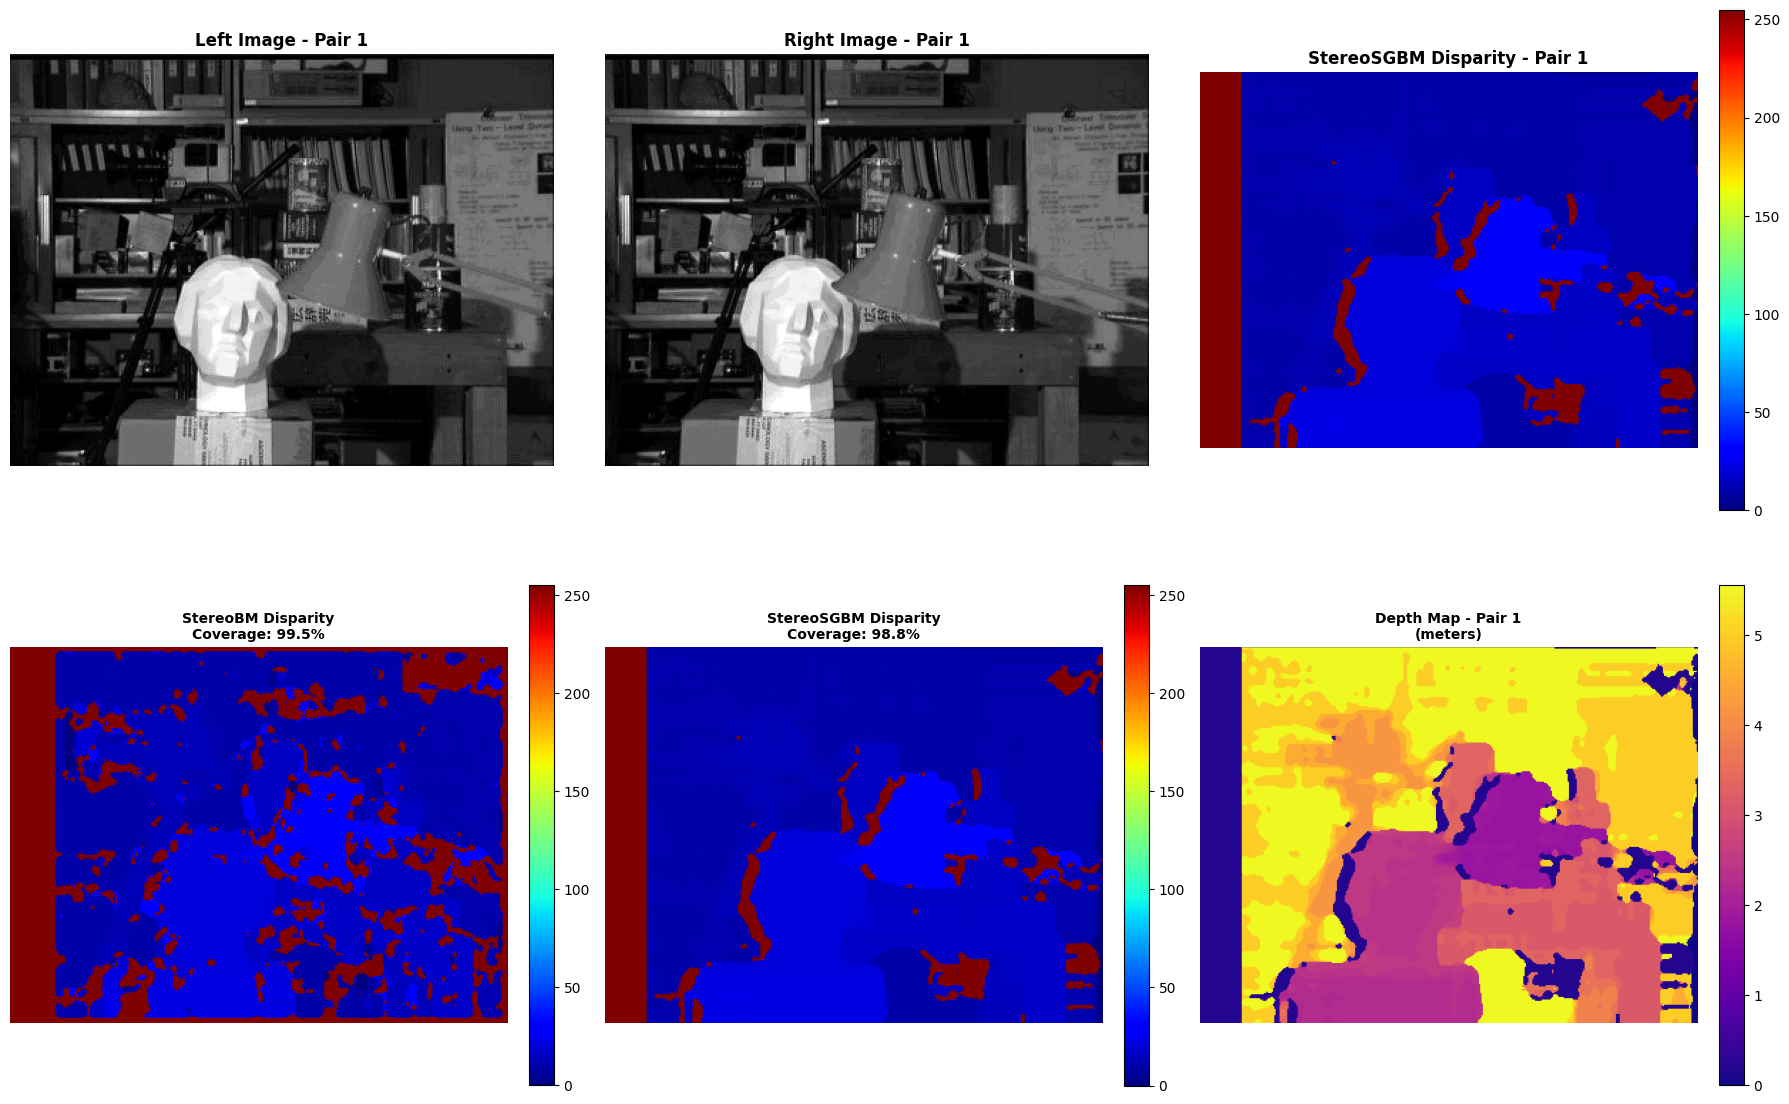


 Displaying results for Stereo Pair 2


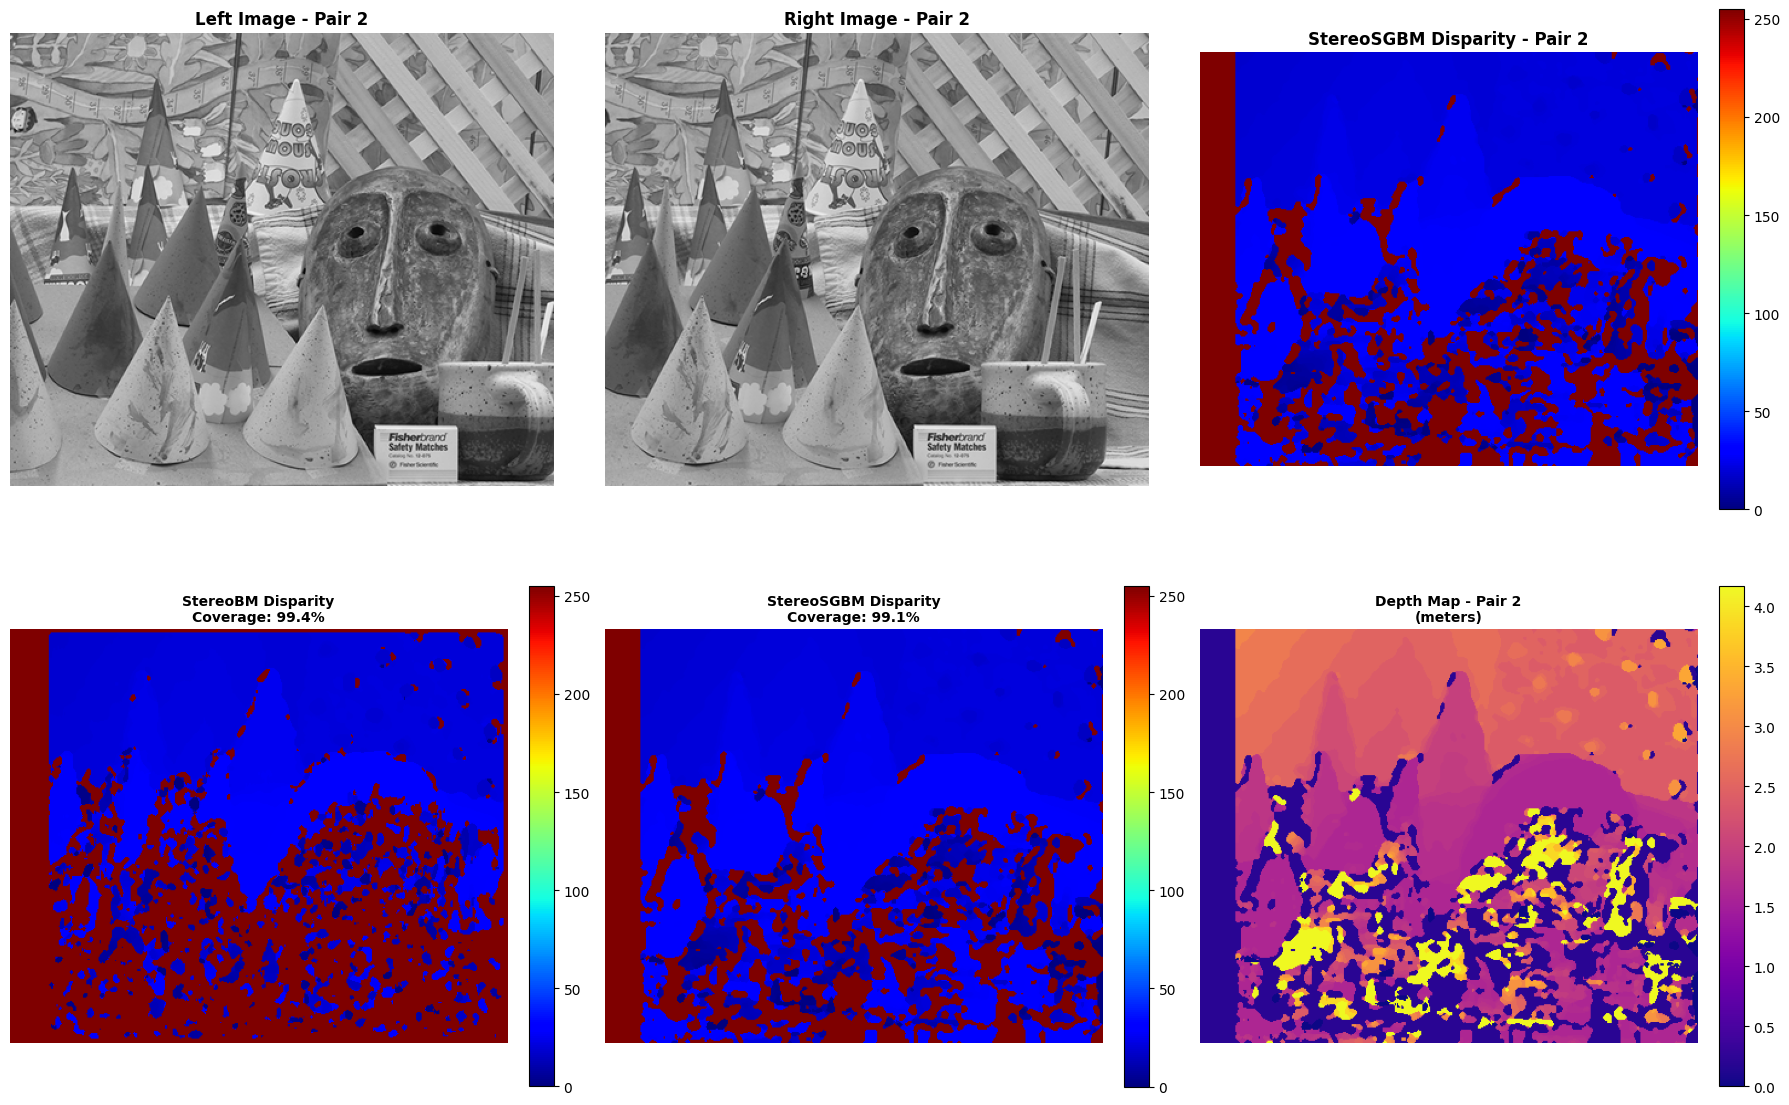


 Displaying results for Stereo Pair 3


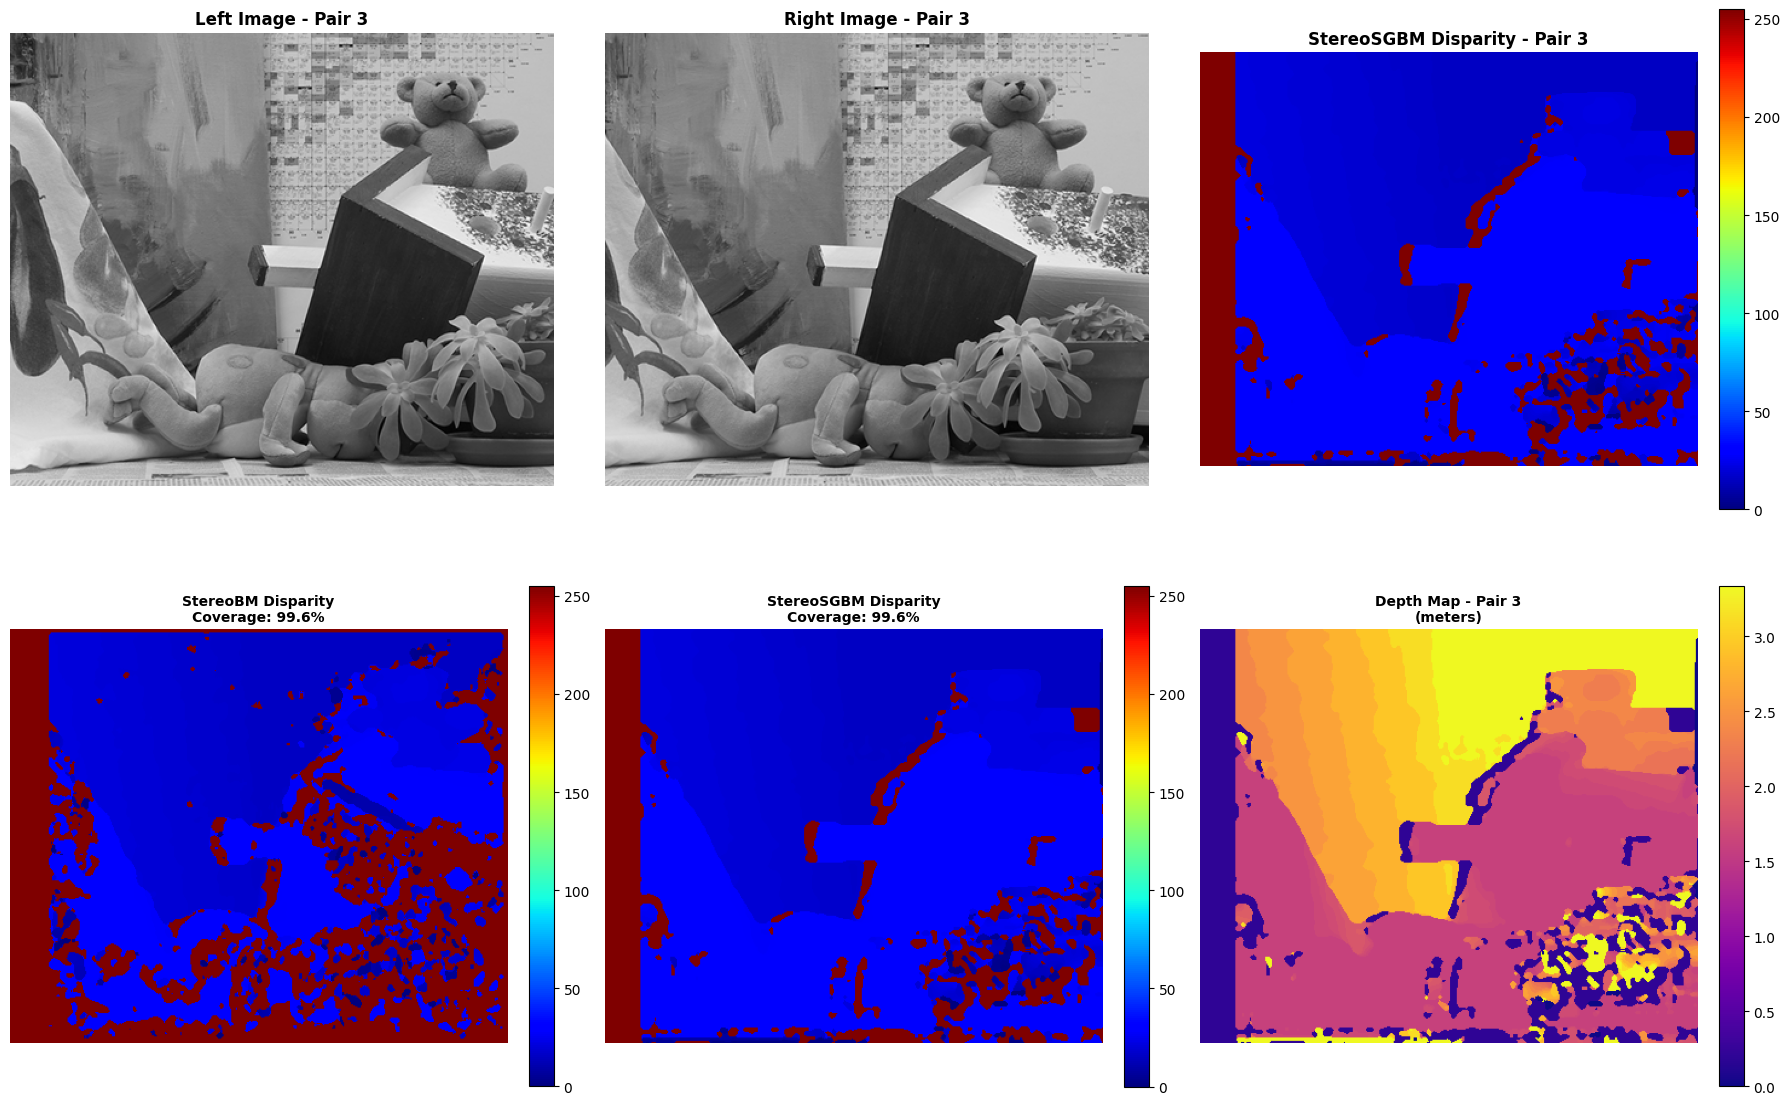


 Creating performance summary...


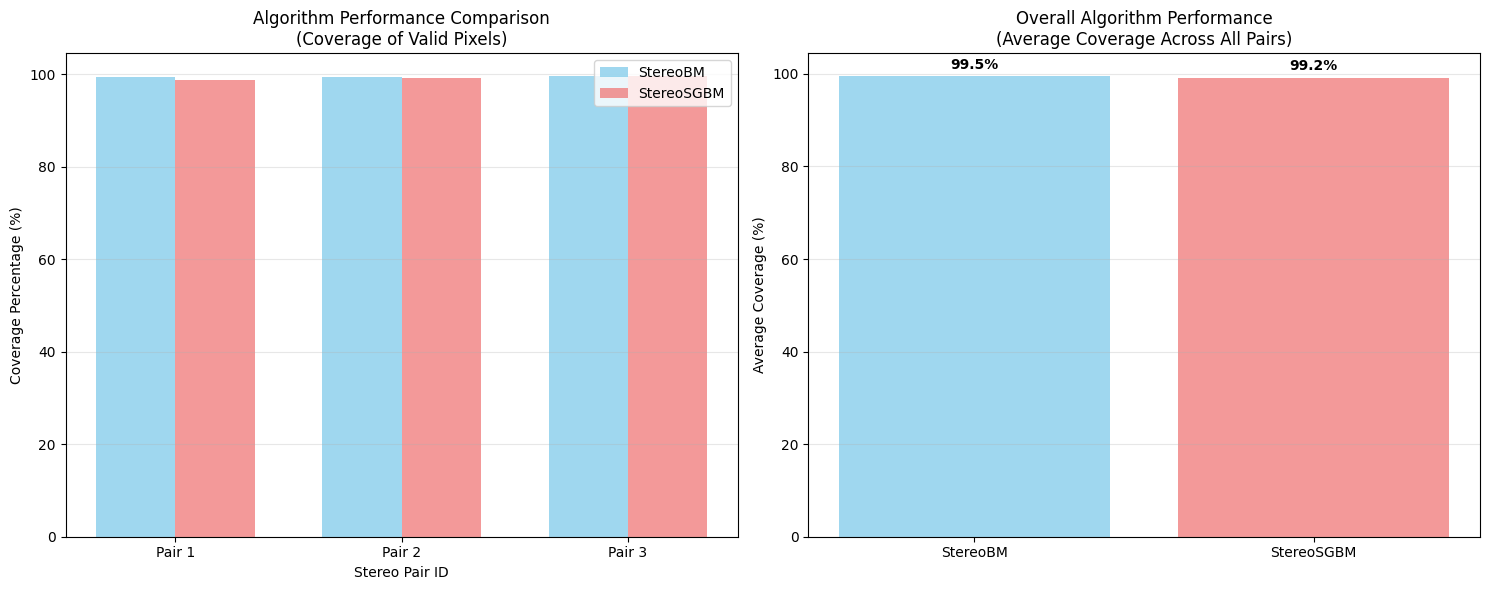

 PERFORMANCE SUMMARY
Total Stereo Pairs Processed: 3
Average StereoBM Coverage: 99.50%
Average StereoSGBM Coverage: 99.17%
Best Performing Algorithm: StereoBM


In [11]:
# Visualize all processed stereo pairs
print(" Visualizing stereo vision results...")

if results:
    # Show results for each stereo pair
    for result in results:
        print(f"\n Displaying results for Stereo Pair {result['pair_id']}")
        visualize_stereo_results(result)

    # Show performance summary
    print("\n Creating performance summary...")
    create_performance_summary(results)

else:
    print(" No results available for visualization")


 Generating 3D point clouds...

🔄 Processing 3D point cloud for Pair 1
 Generated 3D point cloud with 5000 points


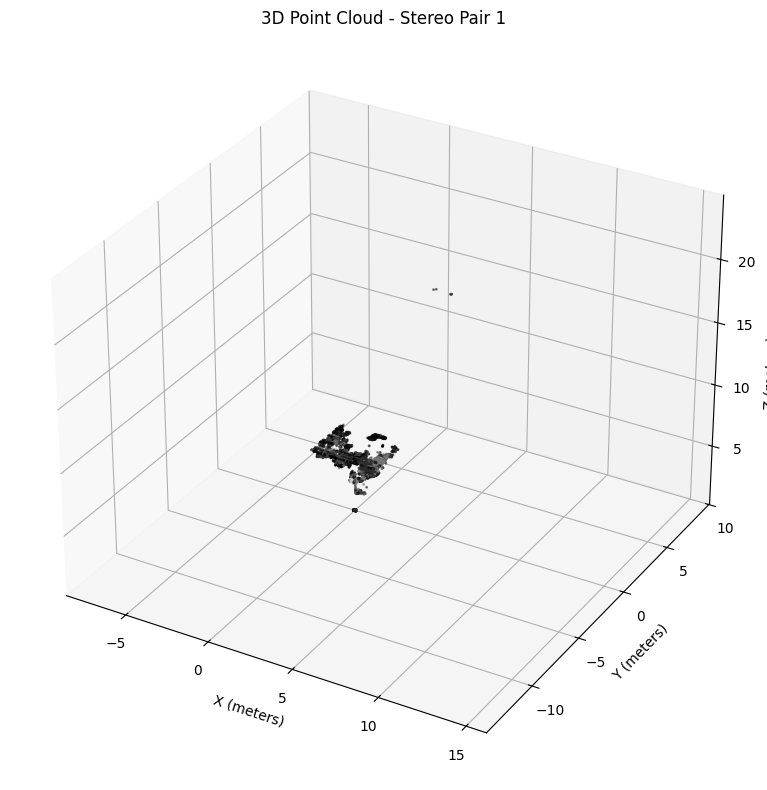


🔄 Processing 3D point cloud for Pair 2
 Generated 3D point cloud with 5000 points


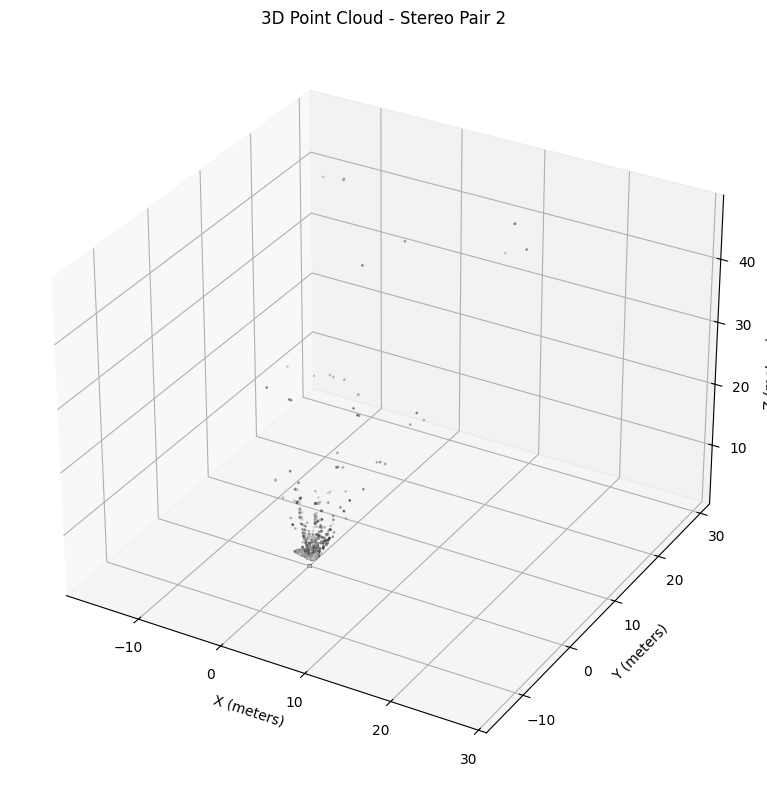


🔄 Processing 3D point cloud for Pair 3
 Generated 3D point cloud with 5000 points


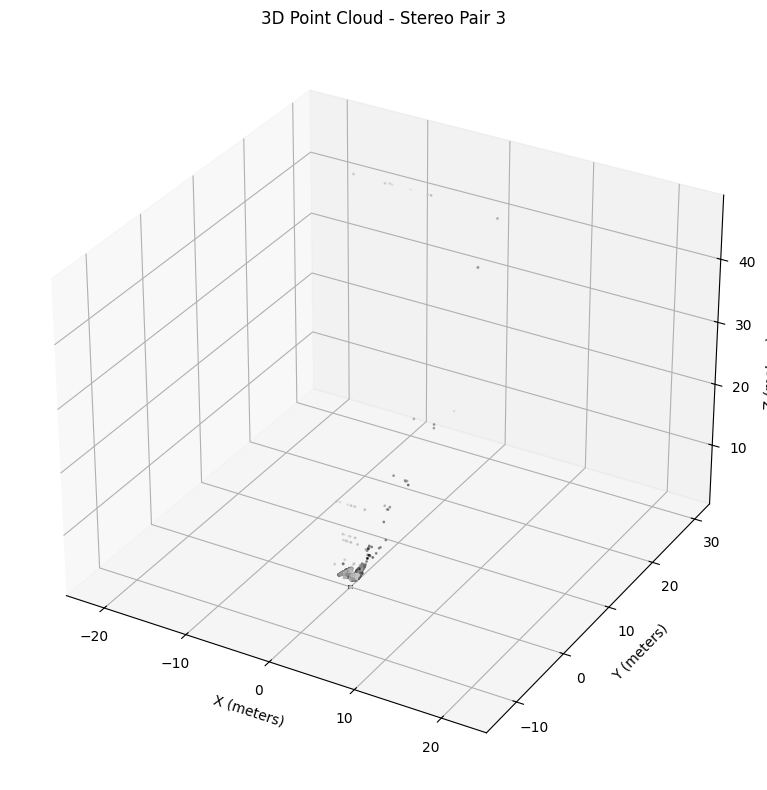

In [12]:
# Generate 3D point cloud from depth data
def create_3d_pointcloud(result, max_points=5000):
    """Generate 3D point cloud from depth map"""
    depth = result['depth_sgbm']
    img_left = result['left_image_orig']

    h, w = depth.shape

    # Create coordinate grids
    x, y = np.meshgrid(np.arange(w), np.arange(h))

    # Valid pixels (non-zero depth)
    valid = depth > 0

    if valid.sum() == 0:
        print(f" No valid depth data for 3D point cloud generation")
        return None, None

    # Sample points if too many (for performance)
    if valid.sum() > max_points:
        valid_indices = np.where(valid)
        sample_indices = np.random.choice(len(valid_indices[0]), max_points, replace=False)

        x_3d = x[valid_indices][sample_indices]
        y_3d = y[valid_indices][sample_indices]
        z_3d = depth[valid_indices][sample_indices]
        colors = img_left[valid_indices][sample_indices]
    else:
        x_3d = x[valid]
        y_3d = y[valid]
        z_3d = depth[valid]
        colors = img_left[valid]

    # Convert to real-world coordinates (simplified)
    focal_length = 500.0
    x_3d = (x_3d - w/2) * z_3d / focal_length
    y_3d = (y_3d - h/2) * z_3d / focal_length

    points_3d = np.column_stack((x_3d, y_3d, z_3d))

    print(f" Generated 3D point cloud with {len(points_3d)} points")

    return points_3d, colors

def visualize_3d_pointcloud(points_3d, colors, pair_id):
    """Visualize 3D point cloud"""
    if points_3d is None:
        return

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    scatter = ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
                        c=colors, cmap='gray', s=1, alpha=0.6)

    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    ax.set_zlabel('Z (meters) - Depth')
    ax.set_title(f'3D Point Cloud - Stereo Pair {pair_id}')

    # Set equal aspect ratio
    max_range = np.array([points_3d[:, 0].max() - points_3d[:, 0].min(),
                         points_3d[:, 1].max() - points_3d[:, 1].min(),
                         points_3d[:, 2].max() - points_3d[:, 2].min()]).max() / 2.0

    mid_x = (points_3d[:, 0].max() + points_3d[:, 0].min()) * 0.5
    mid_y = (points_3d[:, 1].max() + points_3d[:, 1].min()) * 0.5
    mid_z = (points_3d[:, 2].max() + points_3d[:, 2].min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    plt.tight_layout()
    plt.show()

# Generate 3D point clouds for all results
print(" Generating 3D point clouds...")

if results:
    for result in results:
        print(f"\n🔄 Processing 3D point cloud for Pair {result['pair_id']}")
        points_3d, colors = create_3d_pointcloud(result)

        if points_3d is not None:
            visualize_3d_pointcloud(points_3d, colors, result['pair_id'])
        else:
            print(f" Skipping 3D visualization for Pair {result['pair_id']} - insufficient depth data")
else:
    print(" No results available for 3D point cloud generation")


In [14]:
# Save processed results
def save_stereo_results(results, output_dir='stereo_vision_results'):
    """Save all processed stereo vision results"""

    os.makedirs(output_dir, exist_ok=True)

    for result in results:
        pair_id = result['pair_id']
        pair_dir = os.path.join(output_dir, f"pair_{pair_id}")
        os.makedirs(pair_dir, exist_ok=True)

        # Save original images
        cv2.imwrite(os.path.join(pair_dir, 'left_original.png'), result['left_image_orig'])
        cv2.imwrite(os.path.join(pair_dir, 'right_original.png'), result['right_image_orig'])

        # Save disparity maps (normalized for visualization)
        if result['disparity_bm'].max() > 0:
            disp_bm_norm = cv2.normalize(result['disparity_bm'], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            cv2.imwrite(os.path.join(pair_dir, 'disparity_bm.png'), disp_bm_norm)

        if result['disparity_sgbm'].max() > 0:
            disp_sgbm_norm = cv2.normalize(result['disparity_sgbm'], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            cv2.imwrite(os.path.join(pair_dir, 'disparity_sgbm.png'), disp_sgbm_norm)

        # Save depth maps
        depth_valid = result['depth_sgbm'][result['depth_sgbm'] > 0]
        if len(depth_valid) > 0:
            depth_norm = cv2.normalize(result['depth_sgbm'], None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
            cv2.imwrite(os.path.join(pair_dir, 'depth_map.png'), depth_norm)

        # Save raw numpy arrays for further processing
        np.save(os.path.join(pair_dir, 'disparity_bm_raw.npy'), result['disparity_bm'])
        np.save(os.path.join(pair_dir, 'disparity_sgbm_raw.npy'), result['disparity_sgbm'])
        np.save(os.path.join(pair_dir, 'depth_raw.npy'), result['depth_sgbm'])

        # Save metadata
        metadata = {
            'pair_id': pair_id,
            'coverage_bm': float(result['coverage_bm']),
            'coverage_sgbm': float(result['coverage_sgbm']),
            'valid_pixels_bm': int(result['valid_pixels_bm']),
            'valid_pixels_sgbm': int(result['valid_pixels_sgbm']),
            'image_shape': result['left_image_orig'].shape,
            'disparity_range_bm': [float(result['disparity_bm'].min()), float(result['disparity_bm'].max())],
            'disparity_range_sgbm': [float(result['disparity_sgbm'].min()), float(result['disparity_sgbm'].max())],
            'depth_range': [float(result['depth_sgbm'][result['depth_sgbm'] > 0].min()),
                          float(result['depth_sgbm'][result['depth_sgbm'] > 0].max())] if len(depth_valid) > 0 else [0, 0]
        }

        import json
        with open(os.path.join(pair_dir, 'metadata.json'), 'w') as f:
            json.dump(metadata, f, indent=2)

    print(f" All results saved to {output_dir}/ directory")
    return output_dir

# Save all results
if results:
    output_directory = save_stereo_results(results)


else:
    print("❌ No results were generated. Please check the previous cells for errors.")


 All results saved to stereo_vision_results/ directory
